# A/B Testing Project

# 1. Experiment Design

## 1.1. Metric Choice

Invariant metrics: 
- **Number of cookies**: That is, number of unique cookies to view the course overview page. (dmin=3000)
- **Number of clicks**: That is, number of unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger). (dmin=240)
- **Click-through-probability**: That is, number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page. 

Evaluation metrics:
- **Gross conversion**: That is, number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. (dmin= 0.01)
- **Retention**: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of user-ids to complete checkout. (dmin=0.01)
- **Net conversion**: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. (dmin= 0.0075)

Other metric:
- **Number of user-ids**: That is, number of users who enroll in the free trial. (dmin=50)


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import binom
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
import seaborn as sns

In [2]:
# rough estimates of the baseline values for these metrics 
df_base = pd.read_excel('Final Project Baseline Values.xlsx',header=None)
df_base

,0,1
0,Unique cookies to view page per day:,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109313


## 1.2. Measuring Variability

In [3]:
n = 5000 # sample size  of cookies
gross_conv = df_base.loc[4][1]
reten = df_base.loc[5][1]
net_conv = df_base.loc[6][1]
CTP = df_base.loc[3][1]
d_min_GC = .01
d_min_R = .01
d_min_NC = .0075

In [4]:
SE_GC= round(np.sqrt(gross_conv*(1-gross_conv)/(n*CTP)),4)
SE_R = round(np.sqrt(reten*(1-reten)/(n*CTP*gross_conv)),4)
SE_NC = round(np.sqrt(net_conv*(1-net_conv)/(n*CTP)),4)
print SE_GC,SE_NC,SE_R

0.0202 0.0156 0.0549


## 1.3. Sizing

#### 1.3.i. Choosing Number of Samples given Power

In [5]:
def get_z_star(alpha):
    return round(norm.ppf(1-alpha/2),2)
        
def get_beta(d,s,N,z_star):
    SE = s /  np.sqrt(N)
    beta = norm.cdf(SE*z_star, loc=d, scale=SE) 
    return beta 

def required_size(s,d_min,beta=.2,alpha=.05,Ns=np.arange(10, 50000000, 50)):
    for n in Ns:
        if get_beta(d_min,s,n,get_z_star(alpha)) < beta:
            return n

In [6]:
total_ss_G =2*(required_size(s=np.sqrt(gross_conv*(1-gross_conv)*2), d_min=d_min_GC)/CTP)
total_ss_R =2*(required_size(s=np.sqrt(reten*(1-reten)*2), d_min=d_min_R)/(CTP*gross_conv))
total_ss_N =2*(required_size(s=np.sqrt(net_conv*(1-net_conv)*2), d_min=d_min_NC)/CTP)

total_ss_G, total_ss_R, total_ss_N

(642750.0, 4740606.0606060605, 680250.0)

*Note1 : only 0.08 pageview leads to click.
*Note2: double pageview because we need total pageview for both experiment & control group

The number of pageviews needed is 680250, which is a very large number. The duration to generate the traffic is unrealistic for a A/B testing (see next section). Thus retention will not be used as evaluation metric. The number of pageviews needed for this experiment will be 680250.

#### 1.3.ii. Choosing Duration vs. Exposure

100% of Udacity's traffic will be diverted to this experiment.

Changing whether users are given additional information that will only keep them more informed about a decision that, in the first place, doesn’t cost them any money and doesn’t put any of their personal information at risk, is not itself a “risky” change; therefore, there is no reason to restrict the experiment to any subset of the population

In [7]:
import math 

pageviews = df_base[1][0]  # Unique cookies to view page per day:
# Days needed to complete experiment
days_G = math.ceil(total_ss_G/pageviews) 
days_N = math.ceil(total_ss_N/pageviews) 
days_R = math.ceil(total_ss_R/pageviews) 

print 'To complete the experiment', days_G, 'are needed for gross_conv metric'
print 'To complete the experiment', days_N, 'are needed for net_conv metric'
print 'To complete the experiment', days_R, 'are needed for reten metric'

To complete the experiment 17.0 are needed for gross_conv metric
To complete the experiment 18.0 are needed for net_conv metric
To complete the experiment 119.0 are needed for reten metric


As the retention metric needs 119 days to collect the needed pageviews, it is not suitable for evaluation metric in A/B testing. For 100% exposure, it will take 18 days to complete the testing, which is a suitable duration for the experiment.

# 2. Analysis

- **Pageviews**: Number of unique cookies to view the course overview page that day.
- **Clicks**: Number of unique cookies to click the course overview page that day.
- **Enrollments**: Number of user-ids to enroll in the free trial that day.
- **Payments**: Number of user-ids who who enrolled on that day to remain enrolled for 14 days and thus make a payment. (Note that the date for this column is the start date, that is, the date of enrollment, rather than the date of the payment. The payment happened 14 days later. Because of this, the enrollments and payments are tracked for 14 fewer days than the other columns.)

In [8]:
df_cont = pd.read_excel('Final Project Results.xlsx',sheetname='Control')
df_exp = pd.read_excel('Final Project Results.xlsx',sheetname='Experiment')
#df_cont.Date.map(lambda x: x.split()[0][:3])
df_cont.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [9]:
df_cont.tail()

,Date,Pageviews,Clicks,Enrollments,Payments
32,"Wed, Nov 12",10134,801,NaN,NaN
33,"Thu, Nov 13",9717,814,NaN,NaN
34,"Fri, Nov 14",9192,735,NaN,NaN
35,"Sat, Nov 15",8630,743,NaN,NaN
36,"Sun, Nov 16",8970,722,NaN,NaN


## 2.1. Sanity Checks

Check whether your invariant metrics are equivalent between the two groups
- Number of cookies: Count - binominal test
- Number of clicks: Count - binominal test
- Click-through-probability:  check whether the difference between group values falls within that confidence level

#### 2.1.i. Number of cookies

In [10]:
p = .5 # H_null : The cookies are distributed evenly
n_pv_cont =np.sum(df_cont.Pageviews)
n_pv_exp = np.sum(df_exp.Pageviews)
SD_pv = np.sqrt(.5*(1-.5)/(n_pv_cont+n_pv_exp))
p_hat = round(n_pv_cont/(n_pv_exp+n_pv_cont),4)
m = norm.ppf(.975)*SD_pv
CI = round(p-m,4),round(p+m,4)
p_hat,CI
# observed value is between the upper and lower bounds

(0.5006, (0.4988, 0.5012))

#### 2.1.ii. Number of clicks

In [11]:
p = .5 # H_null : The clicks are distributed evenly
n_click_cont =np.sum(df_cont.Clicks)
n_click_exp = np.sum(df_exp.Clicks)
SD_click = np.sqrt(.5*(1-.5)/(n_click_cont+n_click_exp))
p_hat = round(n_click_cont/(n_click_exp+n_click_cont),4)
m = norm.ppf(.975)*SD_click
CI = round(p-m,4),round(p+m,4)
p_hat,CI
# observed value is between the upper and lower bounds

(0.5005, (0.4959, 0.5041))

#### 2.1.iii. Click-through-probability

In [12]:
d = 0 # H_null : CTP_exp - CTP_cont = 0
p_hat_cont = n_click_cont/ n_pv_cont
p_hat_exp = n_click_exp/ n_pv_exp
p_hat_pool = (n_click_cont+n_click_exp)/ (n_pv_cont + n_pv_exp)
d_hat = round(p_hat_exp-p_hat_cont,4)
SE_hat_pool = np.sqrt(p_hat_pool*(1-p_hat_pool)*(1/n_pv_cont+1/n_pv_exp))
m = norm.ppf(.975)*SE_hat_pool
CI = round(d-m,4),round(d+m,4)
d_hat,CI
# observed value is between the upper and lower bounds

(0.0001, (-0.0013, 0.0013))

## 2.2. Effect Size Tests - Check for Practical and Statistical Significance 

In [13]:
print df_base[0]
print df_cont.columns

0                 Unique cookies to view page per day:
1    Unique cookies to click "Start free trial" per...
2                                 Enrollments per day:
3     Click-through-probability on "Start free trial":
4               Probability of enrolling, given click:
5                Probability of payment, given enroll:
6                  Probability of payment, given click
Name: 0, dtype: object
Index([u'Date', u'Pageviews', u'Clicks', u'Enrollments', u'Payments'], dtype='object')


#### 2.2.i. Gross conversion 
Probability of enrolling, given click = enrollments / clicks

In [29]:
n_enroll_cont = np.sum(df_cont.Enrollments>0)
p_hat_cont = np.sum(df_cont.Enrollments)/np.sum(df_cont.Clicks[:n_enroll_cont])

n_enroll_exp = np.sum(df_exp.Enrollments>0)
p_hat_exp = np.sum(df_exp.Enrollments)/np.sum(df_exp.Clicks[:n_enroll_exp])

p_hat_pool =  (np.sum(df_exp.Enrollments)+np.sum(df_cont.Enrollments))\
/ (np.sum(df_exp.Clicks[:n_enroll_exp])+np.sum(df_cont.Clicks[:n_enroll_cont]))
# p_hat_cont,p_hat_exp,p_hat_pool

d_hat = round(p_hat_exp-p_hat_cont,4)
SE_hat_pool = np.sqrt(p_hat_pool*(1-p_hat_pool)*\
(1/np.sum(df_exp.Clicks[:n_enroll_exp])+1/np.sum(df_cont.Clicks[:n_enroll_cont])))

m = norm.ppf(.975)*SE_hat_pool
CI = d_hat-m,round(d_hat+m,4)
d,d_min_GC,CI

(0, 0.01, (-0.029168326307143104, -0.012))

As the bound does not cover zero, it is statistically significant. It is also practically significant
because the bound does not cover the practical significance (dmin) of 0.01.

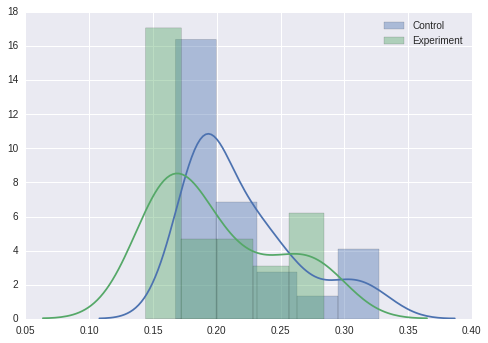

In [28]:
sns.distplot(df_cont.Enrollments[:n_enroll_cont]/df_cont.Clicks[:n_enroll_cont],bins=5,label="Control")
sns.distplot(df_exp.Enrollments[:n_enroll_exp]/df_exp.Clicks[:n_enroll_exp],bins=5,label="Experiment")
plt.legend();

The comparison of the distributions of experiment and control group's gross conversions is also inline with the alternative hypothesis that the experiment group;s gross conversion is less than the experiment group.

The hypothesis of the experiment is that the screen popup will reduce the number of
frustrated students who left the trial because they do not have enough time. Thus we
expect that the number of students to complete the checkout and enroll in the free trial
should be **reduced** if we launch the feature. Gross conversion is the number of userids
to enroll and complete payment over the number of clicks and it is expected that gross conversion rate should **decrease** to launch the new feature.

#### 2.2.ii. Net conversion

Probability of payment, given click = Payments / Clicks

In [16]:
n_payment_cont = np.sum(df_cont.Payments>0)
p_hat_cont = np.sum(df_cont.Payments)/np.sum(df_cont.Clicks[:n_payment_cont])

n_payment_exp = np.sum(df_exp.Payments>0)
p_hat_exp = np.sum(df_exp.Payments)/np.sum(df_exp.Clicks[:n_payment_exp])

p_hat_pool =  (np.sum(df_exp.Payments)+np.sum(df_cont.Payments))\
/ (np.sum(df_exp.Clicks[:n_payment_exp])+np.sum(df_cont.Clicks[:n_payment_cont]))
# p_hat_cont,p_hat_exp,p_hat_pool

d_hat = round(p_hat_exp-p_hat_cont,4)
SE_hat_pool = np.sqrt(p_hat_pool*(1-p_hat_pool)*\
(1/np.sum(df_exp.Clicks[:n_payment_exp])+1/np.sum(df_cont.Clicks[:n_payment_cont])))

m = norm.ppf(.975)*SE_hat_pool
CI = round(d_hat-m,4),round(d_hat+m,4)
d,d_min_NC,CI

(0, 0.0075, (-0.0116, 0.0018))

As the bound includes zero, it is neither statistically significant and practically significant

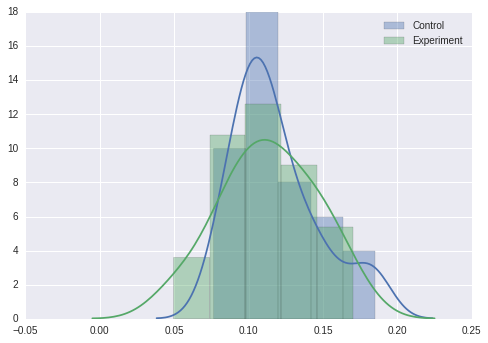

In [17]:
sns.distplot(df_cont.Payments[:n_payment_cont]/df_cont.Clicks[:n_payment_cont],bins=5,label="Control")
sns.distplot(df_exp.Payments[:n_payment_exp]/df_exp.Clicks[:n_payment_exp],bins=5,label="Experiment")
plt.legend();

The comparison of the distributions of experiment and control group's net conversions is also shows that the distributions are more or less the same.

## 2.3. Sign Tests

In [73]:
GC_cont = df_cont.Enrollments[:n_enroll_cont]/df_cont.Clicks[:n_enroll_cont]
GC_exp = df_exp.Enrollments[:n_enroll_exp]/df_exp.Clicks[:n_enroll_exp]
n_pos = np.sum(GC_exp>GC_cont)
n_all = GC_cont.size
p_GC = round(2*binom.cdf(n_pos,n_all,p=.5),4)
n_pos,n_all,p_GC

(4, 23, 0.0026)

In [70]:
NC_cont = df_cont.Payments[:n_payment_cont]/df_cont.Clicks[:n_payment_cont]
NC_exp = df_exp.Payments[:n_payment_exp]/df_exp.Clicks[:n_payment_exp]

n_pos = np.sum(NC_exp>NC_cont)
n_all = NC_cont.size
p_NC = round(2*binom.cdf(n_pos,n_all,p=.5),4)
n_pos,n_all,p_NC,

(10, 23, 0.6776)

## 2.4. Comments

In [80]:
alpha = .05
overall_alpha = (1-(1-alpha)**2)
round(overall_alpha,4) # P(FP>=1)

0.0975

- Issues regarding tracking multiple metrics : The probability at least one metric will show a significant difference if there is no true difference is %9 which is quite small.

- Bonferroni correction: I chose not to use the Bonferroni correction, because in this setting we are checking for a significant  change in both of our evaluation metrics, and not just one . The Bonferroni correction adjusts for the  scenario where we are looking for any significant changes. There are no discrepancies between the effect

- Bonferroni correction was also not used because the metrics in the test has high correlation (high variance) and the Bonferroni correction will be too conservative to it. I completely comprehend the importance to correct if a test is launched and the metrics shows a significant difference, because it's more liely that one of multiple metrics will be falsely positive as the number of metrics increases. However, we would only launch if all evaluation metrics must show a significant change. In that case, there would be no need to use Bonferroni correction. In other words, correction is applied if we are using OR on all metrics, but not if we are testing for AND of all metrics.

- Size tests and the sign tests: the gross conversion change is statistically significant to both tests, and the net conversion change is not statistically significant to both tests

- The experiment shows that the change will significantly decrease the gross conversion rate and
keep the net conversion rate unchanged.

https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub?embedded=True